# 教程：JAX 101

主要翻译：https://jax.readthedocs.io/en/latest/jax-101/index.html

这是由 DeepMind 的工程师和研究员开发的教程。

## JAX As Accelerated NumPy

从根本上讲，JAX是一个库，它可以转换用类似NumPy的API编写的数组运算程序。

现在，可以将JAX视为可在加速器上运行的可微分NumPy。

下面的代码显示了如何导入JAX和创建向量。

In [1]:
import jax
import jax.numpy as jnp

x = jnp.arange(10)
print(x)

[0 1 2 3 4 5 6 7 8 9]


到目前为止，一切都像NumPy。JAX的一大魅力在于不需要学习新的API。用jnp替换np，许多常见的NumPy程序在JAX中也可以很好地运行。在本节末尾我们将涉及一些重要的区别。

如果检查x的类型，您会注意到第一个区别。它是DeviceArray type的变量，这是JAX表示数组的方式。

In [2]:
x

DeviceArray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

JAX的一项有用功能是，同一代码可以在不同的后端（CPU，GPU和TPU）上运行。

现在，我们将执行一个点积，以演示可以在不更改代码的情况下在不同设备中完成它。我们用%timeit来检查性能。

（技术细节：调用JAX函数时，相应的操作将分派给加速器，以便在可能的情况下进行异步计算。因此，返回的数组不一定在函数返回后立即“填充”。因此，如果不立即要求结果，那么该计算就不会阻塞Python执行。因此，除非我们block_until_ready，否则就会只对调度进行计时，而不是对实际计算进行计时（请参阅JAX文档中的异步调度。）

In [3]:
long_vector = jnp.arange(int(1e7))

%timeit jnp.dot(long_vector, long_vector).block_until_ready()

5.92 ms ± 575 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### JAX的第一个转换： grad

JAX的基本功能是它允许您转换函数。

最常用的转换之一是jax.grad，它接受用Python编写的数值函数，并返回一个新的Python函数，该函数可计算原始函数的梯度。

举例，我们首先定义一个函数，该函数接受一个数组并返回平方和。

In [4]:
def sum_of_squares(x):
    return jnp.sum(x**2)

应用jax.grad到sum_of_squares将返回一个不同的function，即sum_of_squares相对于它的第一个参数x的梯度。

然后，您可以在数组上使用该函数以返回数组中每个元素的导数。

In [5]:
sum_of_squares_dx = jax.grad(sum_of_squares)

x = jnp.asarray([1.0, 2.0, 3.0, 4.0])

print(sum_of_squares(x))

print(sum_of_squares_dx(x))

30.0
[2. 4. 6. 8.]


可以认为jax.grad就是向量微积分中的∇运算符。给定函数f(x)，∇f 代表计算函数 f的梯度，即
$$(\nabla f)(x)_i=\frac{\partial f}{\partial x_i}(x)$$
类似地，jax.grad(f)是计算梯度的函数，所以jax.grad(f)(x)是f在x处的梯度。

（类似 ∇，jax.grad仅适用于输出是标量的函数-否则会引发错误。）

这使得JAX API与Tensorflow和PyTorch等其他autodiff库完全不同，在这里我们使用loss张量本身（例如，通过调用loss.backward()）来计算梯度。JAX API直接与函数配合使用，与基础数学保持更紧密的联系。一旦习惯了这种处理方式，您就会感觉很自然：代码中的损失函数实际上是参数和数据的函数，并且您会发现它的梯度就像在数学中一样。

这种处理的方式使控制事情变得很简单，例如要微分哪些变量。默认情况下，jax.grad将找到相对于第一个参数的梯度。在以下示例中，sum_squared_error_dx的结果将是sum_squared_error相对于的梯度x。

In [6]:
def sum_squared_error(x, y):
    return jnp.sum((x-y)**2)

sum_squared_error_dx = jax.grad(sum_squared_error)

y = jnp.asarray([1.1, 2.1, 3.1, 4.1])

print(sum_squared_error_dx(x, y))

[-0.20000005 -0.19999981 -0.19999981 -0.19999981]


要找到相对于一个或多个不同参数的梯度，可以设置argnums：

In [7]:
jax.grad(sum_squared_error, argnums=(0, 1))(x, y)  # Find gradient wrt both x & y

(DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 DeviceArray([0.20000005, 0.19999981, 0.19999981, 0.19999981], dtype=float32))

这是否意味着在进行机器学习时，我们需要编写带有巨大参数列表的函数，并为每个模型参数数组提供一个参数？不需要。JAX配备了将数组捆绑在一起的机制，称为“pytrees”的数据结构，后面会有补充。因此，jax.grad的使用通常如下形式：

```Python
def loss_fn(params, data):
    ...

grads = jax.grad(loss_fn)(params, data_batch)
```

params例如，其中是数组的嵌套字典，而返回的grads是具有相同结构的数组的另一个嵌套字典。

### Value和Grad

通常，需要同时找到函数的值和梯度，例如，记录训练loss。JAX具有便捷的姐妹转换功能，可以有效地完成此任务：

In [8]:
jax.value_and_grad(sum_squared_error)(x, y)

(DeviceArray(0.03999995, dtype=float32),
 DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32))

它返回一个元组（您猜到了）（值，梯度）。准确地说，对任何f：

```Python
jax.value_and_grad(f)(*xs) == (f(*xs), jax.grad(f)(*xs)) 
```

### Auxiliary data

除了要记录该值之外，我们通常还希望在计算损失函数时报告获得的一些中间结果。但是，如果我们尝试使用jax.grad来执行此操作，则会遇到麻烦：

In [9]:
def squared_error_with_aux(x, y):
    return sum_squared_error(x, y), x-y

jax.grad(squared_error_with_aux)(x, y)

TypeError: Gradient only defined for scalar-output functions. Output was (DeviceArray(0.03999995, dtype=float32), DeviceArray([-0.10000002, -0.0999999 , -0.0999999 , -0.0999999 ], dtype=float32)).

这是因为jax.grad仅在标量函数上定义，但我们的新函数返回的是一个元组。可是我们需要返回一个元组以返回中间结果，所以怎么办？这就是用到has_aux的地方：

In [10]:
jax.grad(squared_error_with_aux, has_aux=True)(x, y)

(DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 DeviceArray([-0.10000002, -0.0999999 , -0.0999999 , -0.0999999 ], dtype=float32))

has_aux表示该函数返回一对(out, aux)。它使jax.grad忽略aux ，将其传递给用户，同时使微分功能，就好像只返回了out一样。

### 与NumPy的差异

jax.numpy API紧跟NumPy的API。但是，有一些重要的区别。现在指出一些比较常见的。

最重要的区别（在某种意义上是所有其他区别的根源）是，就像在函数编程中一样，JAX被设计为函数性的。其背后的原因是，JAX支持的程序转换在函数式程序中更加可行。

函数式编程（FP）的介绍不在本指南的范围之内。如果已经熟悉FP，那么在学习JAX时，FP直觉会有所帮助。如果没有，也没事！使用JAX时凭直觉进行函数式编程的重要特点也非常简单：不要编写有side-effects副作用的代码。

副作用是函数的任何未出现在其输出中的效果。一个示例是就地修改数组：

In [11]:
import numpy as np

x = np.array([1, 2, 3])

def in_place_modify(x):
    x[0] = 123
    return None

in_place_modify(x)
x

array([123,   2,   3])

副作用函数修改了其参数，但返回了一个完全不相关的值。修改是一个副作用。

上面的代码将在NumPy中运行。但是，JAX数组不允许对其进行就地修改：

In [12]:
in_place_modify(jnp.array(x))  # Raises error when we cast input to jnp.ndarray

TypeError: '<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable; perhaps you want jax.ops.index_update or jax.ops.index_add instead?

有用的是，该错误指出了JAX通过jax.ops.index_* ops 进行相同操作的无副作用方法。它们类似于按索引进行就地修改，但是是创建一个新数组并进行相应的修改：

In [13]:
def jax_in_place_modify(x):
    return jax.ops.index_update(x, 0, 123)

y = jnp.array([1, 2, 3])
jax_in_place_modify(y)

DeviceArray([123,   2,   3], dtype=int32)

请注意，旧数组未受影响，因此没有副作用：

In [14]:
y

DeviceArray([1, 2, 3], dtype=int32)

无副作用的代码被称为functionally pure，或者 pure。

pure 版本的效率不高吗？严格来说，是的。因为正在创建一个新的数组。但是，JAX计算通常是在使用另一个程序转换jax.jit运行之前进行编译的。如果在使用jax.ops.index_update()对其进行“原位”修改后不使用旧数组，则编译器可以识别出它实际上可以编译为原位修改，从而最终获得了有效的代码。

当然，可以混合使用副作用较大的Python代码和功能上纯的JAX代码。随着对JAX的熟悉，将学习如何以及何时可以使用它。根据经验，任何打算由JAX转换的函数都应避免副作用，而JAX原语本身会尽力帮助做到这一点。

### 第一个JAX training loop

仍然有很多关于JAX的知识，但是已经足够了解如何使用JAX来构建一个简单的训练循环。

为了简单起见，从线性回归开始。

数据是根据 $y=\omega _{true}x+b_{true}+\epsilon$

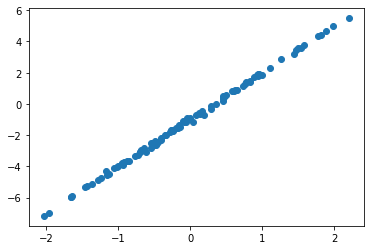

In [15]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys);

因此，模型是 $\hat y(x;\theta)=\omega x+b$

我们将使用单个数组来容纳两个参数：theta = [w, b]

In [16]:
def model(theta, x):
    """Computes wx + b on a batch of input x."""
    w, b = theta
    return w * x + b

损失函数是 $J(x,y;\theta)=(\hat y-y)^2$

In [17]:
def loss_fn(theta, x, y):
    prediction = model(theta, x)
    return jnp.mean((prediction-y)**2)

我们如何优化损失函数？使用梯度下降。在每个更新步骤中，我们将找到参数的loss的梯度，并在最速下降方向上走一小步：

$$\theta _{new}=\theta-0.1(\nabla _{\theta}J)(x,y;θ)$$

In [18]:
def update(theta, x, y, lr=0.1):
    return theta - lr * jax.grad(loss_fn)(theta, x, y)

在JAX中，通常会定义一个每个步骤都被调用的update()函数，将当前参数作为输入并返回新参数。这是JAX函数性质的自然结果。下面稍作解释。

在机器学习中，程序状态通常以以下形式出现：

- 模型参数
- 优化器状态，
- 有状态层，例如BatchNorm。

某些JAX转换（最值得注意的是jax.jit）对其转换的函数施加了约束。特别是，由jax.jit转换的函数必须没有副作用。这是因为，当在编译过程中运行该函数的python版本时，任何此类副作用都只会执行一次。这些副作用将不会在随后的运行中由已编译的函数执行。

更改程序状态是一种副作用。那么如果不要副作用，如何更新模型参数，优化器状态以及在模型中使用有状态层呢？简单的答案是：使用函数式编程。

然后，可以对该功能进行整体JIT编译，以实现最高效率。下一指南将确切解释其jax.jit工作原理，但是如果愿意，您可以尝试@jax.jit在update()定义之前添加，然后查看下面的训练循环如何更快地运行。

从一个简单的有状态程序开始：一个计数器。

In [19]:
import jax
import jax.numpy as jnp

class Counter:
    """A simple counter."""
    def __init__(self):
        self.n = 0

    def count(self) -> int:
        """Increments the counter and returns the new value."""
        self.n += 1
        return self.n
    
    def reset(self):
        """Resets the counter to zero."""
        self.n = 0

counter = Counter()

for _ in range(3):
    print(counter.count())

1
2
3


该n属性在count的连续调用之间保持计数器的状态。它就是调用count的副作用。

假设我们要快速计数，所以使用jax.jit 加速 count方法。（在此示例中，出于多种原因，这实际上并没有帮助提高速度，但是可以将其视为希望通过JIT编译模型参数的更新的玩具模型，认为jax.jit会带来很大的不同）。

In [20]:
counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
    print(fast_count())

1
1
1


不好了！计数器不工作了。这是因为这行代码：self.n += 1

当JAX编译方法调用时，它在count中只被调用一次。而且，由于返回值不依赖于count的参数，一旦返回第一个1，后续对fast_count的调用将始终返回1。那么，我们该如何解决呢？

**解决方案：显式状态**

计数器的部分问题是返回的值不依赖于参数，这意味着将常量送到编译后的输出中。但这不应该是一个常数-它应该取决于状态。好吧，那为什么不把状态变成一个参数呢？

In [21]:
from typing import Tuple

CounterState = int

class CounterV2:
    def count(self, n: CounterState) -> Tuple[int, CounterState]:
        # You could just return n+1, but here we separate its role as 
        # the output and as the counter state for didactic purposes.
        return n+1, n+1
    def reset(self) -> CounterState:
        return 0

counter = CounterV2()
state = counter.reset()

for _ in range(3):
    value, state = counter.count(state)
    print(value)

1
2
3


在这个新版本的Counter中，将n作为count的参数，并添加了另一个返回值表示新的更新的状态。要使用此计数器，我们现在需要显式跟踪状态。但是作为回报，我们现在可以放心地使用jax.jit此计数器：

In [22]:
state = counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
    value, state = fast_count(state)
    print(value)

1
2
3


归纳下一般策略。

我们可以将相同的过程应用于任何有状态方法，以将其转换为无状态方法。

```Python
class StatefulClass

    state: State
        
    def stateful_method(*args, **kwargs) -> Output:
```

并把它变成一类形式

```Python
class StatelessClass
    
    def stateless_method(state: State, *args, **kwargs) -> (Output, State):
```

这是一种常见的函数编程模式，从本质上讲，这是在所有JAX程序中处理状态的方式。

注意，一旦我们用这种方式重写了它，对一个类的需求就变得不那么清楚了。我们可以就仅保留stateless_method，因为该类已经不再从事任何工作。因为就像我们刚刚应用的策略一样，面向对象编程（OOP）也就是帮助程序员理解程序状态的一种方式，并不比函数式编程特别。

在前面的例子中，CounterV2类不过是一个命名空间，它使用的所有功能都放在CounterState一个位置。所以：您认为将类保留还有意义吗？

回到线性回归的例子，通过梯度下降的线性回归。

在这里，我们只处理一种状态：模型参数。但是通常，会看到许多状态被传入和传出JAX函数，例如优化器状态，batchnorm的层统计信息等。

注意update函数，可以看到theta是作为函数参数的。

w: 3.01, b: -1.00


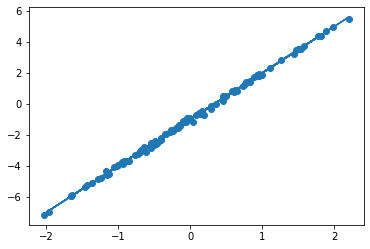

In [23]:
theta = jnp.array([1., 1.])

for _ in range(1000):
    theta = update(theta, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs))

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")

此基本方法几乎构成了将在JAX中实现的所有training循环的基础。此示例与实际训练循环之间的主要区别在于模型比较简单：使用单个数组就能容纳所有参数。接下来的pytree指南中将记录如何管理更多参数。

## Working with Pytrees

通常，我们想对看起来像数组的字典，字典列表或其他嵌套结构的对象进行操作。在JAX中，将它们称为pytrees，有时它们也被称为nests，或就叫trees。

JAX在其库函数中以及通过使用来自jax.tree_utils（还有一系列jax.tree_* ）的函数提供对此类对象的内置支持。本小节将说明如何使用它们，给出一些有用的代码片段并指出常见的陷阱。

什么是pytree？

JAX pytree docs中是这样定义的：

“pytree是叶元素和/或更多pytree的容器。**容器包括列表，元组和字典**。**叶元素是非pytree的任何元素**，例如数组。换句话说，pytree只是一个可能嵌套的标准或用户注册的Python容器。如果嵌套，请注意容器类型不需要匹配。单个“叶”（即非容器对象）也被视为pytree。”

一些示例pytrees：

In [24]:
import jax
import jax.numpy as jnp

example_trees = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]),
]

# Let's see how many leaves they have:
for pytree in example_trees:
    leaves = jax.tree_leaves(pytree)
    print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 'a', <object object at 0x7ff9d41f18b0>]   has 3 leaves: [1, 'a', <object object at 0x7ff9d41f18b0>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
DeviceArray([1, 2, 3], dtype=int32)           has 1 leaves: [DeviceArray([1, 2, 3], dtype=int32)]


我们还引入了第一个jax.tree_* 功能，该功能使我们能够从树中提取展平的叶。

为什么要pytrees？

在机器学习中，通常可以用到pytree的一些地方是：

- Model parameters
- Dataset entries
- RL agent observations

在批量处理数据集（例如，字典列表的列表）时，它们通常也很自然地出现。

最常用的pytree函数是jax.tree_map和jax.tree_multimap。它们的工作方式类似于Python的native map，但是可以在整个pytree上使用。

对于带有一个参数的函数，请使用jax.tree_map：

In [25]:
list_of_lists = [
    [1, 2, 3],
    [1, 2],
    [1, 2, 3, 4]
]

jax.tree_map(lambda x: x*2, list_of_lists)

[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

要使用带有多个参数的函数，请使用jax.tree_multimap：

In [26]:
another_list_of_lists = list_of_lists
jax.tree_multimap(lambda x, y: x+y, list_of_lists, another_list_of_lists)

[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

对于tree_multimap，输入的结构必须完全匹配。也就是说，列表必须具有相同数量的元素，字典必须具有相同的键，等等。

示例：ML模型参数

训练MLP的一个简单示例显示了pytree运算一些有用的方式：

In [27]:
import numpy as np

def init_mlp_params(layer_widths):
    params = []
    # layer_widths 表示各层的width，用zip连接即可得到每层输入输出大小
    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
        # 每层生成weights和bias，然后给到一个dict中，加入params
        params.append(
            dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
                 biases=np.ones(shape=(n_out,))
                )
        )
    return params

params = init_mlp_params([1, 128, 128, 1])

我们可以用jax.tree_map来检查参数的形状是否符合我们的期望：

In [28]:
# 注意是直接对叶子进行的运算，因为dict并没有shape属性
jax.tree_map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

现在，训练MLP：

In [29]:
def forward(params, x):
    *hidden, last = params
    for layer in hidden:
        x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
    return x @ last['weights'] + last['biases']

def loss_fn(params, x, y):
    return jnp.mean((forward(params, x) - y) ** 2)

LEARNING_RATE = 0.0001

@jax.jit
def update(params, x, y):
    
    grads = jax.grad(loss_fn)(params, x, y)
    # Note that `grads` is a pytree with the same structure as `params`.
    # `jax.grad` is one of the many JAX functions that has
    # built-in support for pytrees.
    
    # This is handy, because we can apply the SGD update using tree utils:
    return jax.tree_multimap(
        lambda p, g: p - LEARNING_RATE * g, params, grads
    )

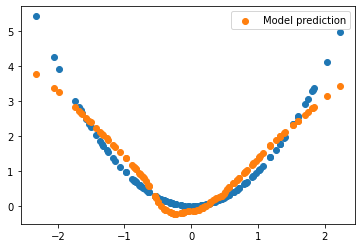

In [30]:
import matplotlib.pyplot as plt

xs = np.random.normal(size=(128, 1))
ys = xs ** 2

for _ in range(1000):
    params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend();

到目前为止，我们仅考虑列表，元组和字典作为pytree。其他所有东西都被视为叶子。因此，如果定义了自己的容器类，则即使其中包含树，也将被视为叶子：

In [31]:
class MyContainer:
    """A named container."""
    def __init__(self, name: str, a: int, b: int, c: int):
        self.name = name
        self.a = a
        self.b = b
        self.c = c

In [32]:
jax.tree_leaves([
    MyContainer('Alice', 1, 2, 3),
    MyContainer('Bob', 4, 5, 6)
])

因此，如果我们尝试使用tree map以期望叶子是容器内的元素，则会收到错误消息：

In [33]:
# MyContainer 本身就是叶子，且我们没有定义+1的运算，所以报错
jax.tree_map(lambda x: x + 1, [
    MyContainer('Alice', 1, 2, 3),
    MyContainer('Bob', 4, 5, 6)
])

TypeError: unsupported operand type(s) for +: 'MyContainer' and 'int'

为了解决这个问题，我们需要向JAX注册我们的容器，告诉容器如何展平和卷起它来：

In [34]:
from typing import Tuple, Iterable

def flatten_MyContainer(container) -> Tuple[Iterable[int], str]:
    """Returns an iterable over container contents, and aux data."""
    flat_contents = [container.a, container.b, container.c]
    
    # we don't want the name to appear as a child, so it is auxiliary data.
    # auxiliary data is usually a description of the structure of a node,
    # e.g., the keys of a dict -- anything that isn't a node's children.
    aux_data = container.name
    return flat_contents, aux_data

def unflatten_MyContainer(
    aux_data: str, flat_contents: Iterable[int]) -> MyContainer:
    """Converts aux data and the flat contents into a MyContainer."""
    return MyContainer(aux_data, *flat_contents)

jax.tree_util.register_pytree_node(
    MyContainer, flatten_MyContainer, unflatten_MyContainer)

jax.tree_leaves([
    MyContainer('Alice', 1, 2, 3),
    MyContainer('Bob', 4, 5, 6)
])

[1, 2, 3, 4, 5, 6]

现代Python配备了有用的工具，可简化容器的定义。其中一些可以直接使用JAX，但其他一些则需要更多注意。例如：

In [35]:
from typing import NamedTuple, Any

class MyOtherContainer(NamedTuple):
    name: str
    a: Any
    b: Any
    c: Any

# Since `tuple` is already registered with JAX, and NamedTuple is a subclass,
# this will work out-of-the-box:
jax.tree_leaves([
    MyOtherContainer('Alice', 1, 2, 3),
    MyOtherContainer('Bob', 4, 5, 6)
])

['Alice', 1, 2, 3, 'Bob', 4, 5, 6]

注意，该name字段现在显示为叶子，因为所有元组元素都是子元素。这就是我们为不必辛苦注册该class而付出的代价。

要注意的一个常见问题是不小心引入了树节点而不是叶子：

In [36]:
a_tree = [jnp.zeros((2, 3)), jnp.zeros((3, 4))]

# Try to make another tree with ones instead of zeros
shapes = jax.tree_map(lambda x: x.shape, a_tree)
jax.tree_map(jnp.ones, shapes)

[(DeviceArray([1., 1.], dtype=float32),
  DeviceArray([1., 1., 1.], dtype=float32)),
 (DeviceArray([1., 1., 1.], dtype=float32),
  DeviceArray([1., 1., 1., 1.], dtype=float32))]

因为shape数组的元素是元组：

In [50]:
shapes

[(2, 3), (3, 4)]

元组是一个pytree节点，其元素才是叶子。因此，在map中，不是对(2, 3)调用jnp.ones，而是对2和3调用，同样对3和4，所以最后是4个数组。

解决方案具体情况具体分析，但有两个较常用的方式：

- 重写代码以避免中间错误tree_map。
- 将元组转换为np.array或jnp.array，从而使整个序列成为一片叶子。

另外注意，jax.tree_utils视None为没有子节点的节点，而不是叶子：

In [37]:
jax.tree_leaves([None, None, None])

[]

如果想转置pytree，即将树列表变成列表树，则可以使用jax.tree_multimap：

In [38]:
def tree_transpose(list_of_trees):
    """Convert a list of trees of identical structure into a single tree of lists."""
    return jax.tree_multimap(lambda *xs: list(xs), *list_of_trees)


# Convert a dataset from row-major to column-major:
episode_steps = [dict(t=1, obs=3), dict(t=2, obs=4)]
tree_transpose(episode_steps)

{'obs': [3, 4], 't': [1, 2]}

对于更复杂的转置，JAX提供了jax.tree_transpose，它更加冗长，但是允许指定内部和外部Pytree的结构以提高灵活性：

In [39]:
jax.tree_transpose(
  outer_treedef = jax.tree_structure([0 for e in episode_steps]),
  inner_treedef = jax.tree_structure(episode_steps[0]),
  pytree_to_transpose = episode_steps
)

{'obs': [3, 4], 't': [1, 2]}

有关JAX中的pytree及其可用操作的更多信息，请参见JAX文档中的pytrees部分。